In [140]:
# !/opt/conda/bin/python -m pip install --upgrade pip
# !pip install imblearn
# !pip install -U imbalanced-learn
# !pip install pyecharts
# !pip install lightgbm

In [141]:
# libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from pyecharts.charts import Line,Bar,Tab
from pyecharts import options as opts
import matplotlib.pyplot as plt

# notebook assets
from pyecharts.globals import CurrentConfig, OnlineHostType
CurrentConfig.ONLINE_HOST = OnlineHostType.NOTEBOOK_HOST
CurrentConfig.ONLINE_HOST
from pyecharts.charts import Bar
from pyecharts.charts import Bar
bar = Bar()


In [142]:
# read file
data = pd.read_csv('./brain_stroke.csv')
data.head()
data.tail()
data.shape
data.describe()
data.info()
print(data.isnull().sum())
# no missing value

import pandas as pd

df = pd.DataFrame(data)

# complete rate for each data filed
total_rows = len(df)
complete_rates = {}

for column in df.columns:
    non_null_count = df[column].count()
    complete_rate = (non_null_count / total_rows) * 100
    complete_rates[column] = complete_rate

print("Complete Rates:")
for column, rate in complete_rates.items():
    print(f"{column}: {rate:.2f}%")


threshold = 3.2

# z score quantile
z_scores = np.abs((df - df.mean()) / df.std())

# judge if is outlier
outliers = z_scores > threshold

# outlier rate of every data field
total_rows = len(df)
outlier_percentages = {}

for column in df.columns:
    outlier_count = outliers[column].sum()
    outlier_percentage = (outlier_count / total_rows) * 100
    outlier_percentages[column] = outlier_percentage

print("Outlier Percentages:")
for column, percentage in outlier_percentages.items():
    print(f"{column}: {percentage:.2f}%")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16340\2813893437.py:32: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  z_scores = np.abs((df - df.mean()) / df.std())


In [143]:
data[data.duplicated()]
# no duplicates

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [144]:
# data projection
# mapping gender and marriage status, with females represented as 0 males represented as 1
data['gender'] = data['gender'].apply(lambda x:1 if x=='Male' else 0) 
data['ever_married'] = data['ever_married'].apply(lambda x:1 if x=='Yes' else 0)

# creating new feature for classification
data['bmi_'] = data['bmi'].apply(lambda x:'underweight' if x<18.5 else 'normal weight' if x<23.9 else 'overweight' if x<27.9 else 'obese')
data['avg_glucose_level_'] = data['avg_glucose_level'].apply(lambda x:'low blood sugar' if x<70 else 'normal' if x<100 else 'diabetes')
data['age_'] = pd.cut(data['age'], bins=5)
data.describe()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   gender              4981 non-null   int64   
 1   age                 4981 non-null   float64 
 2   hypertension        4981 non-null   int64   
 3   heart_disease       4981 non-null   int64   
 4   ever_married        4981 non-null   int64   
 5   work_type           4981 non-null   object  
 6   Residence_type      4981 non-null   object  
 7   avg_glucose_level   4981 non-null   float64 
 8   bmi                 4981 non-null   float64 
 9   smoking_status      4981 non-null   object  
 10  stroke              4981 non-null   int64   
 11  bmi_                4981 non-null   object  
 12  avg_glucose_level_  4981 non-null   object  
 13  age_                4981 non-null   category
dtypes: category(1), float64(3), int64(5), object(5)
memory usage: 511.1+ KB


It can be observed that the minimum value in the "age" column is 0.08, which is a floating-point value. It is likely that this value is due to data entry errors.
As a result, it's reasonable to consider removing this entry to maintain the integrity and accuracy of the dataset.

In [145]:
data[data['age'].apply(lambda x:str(x)[-2:]!='.0')].shape[0]/data.shape[0]
# small rate, we can delete

0.021883155992772536

In [146]:
data = data[data['age'].apply(lambda x:str(x)[-2:]=='.0')]
data.describe()

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke
count,4872.000000,4872.000000,4872.000000,4872.000000,4872.000000,4872.000000,4872.000000,4872.000000
mean,0.414204,44.365764,0.098317,0.056445,0.673235,106.197165,28.716626,0.050698
std,0.492635,22.004358,0.297773,0.230803,0.469079,45.345088,6.693729,0.219403
min,0.000000,1.000000,0.000000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,0.000000,27.000000,0.000000,0.000000,0.000000,77.342500,24.000000,0.000000
50%,0.000000,46.000000,0.000000,0.000000,1.000000,91.910000,28.300000,0.000000
75%,1.000000,62.000000,0.000000,0.000000,1.000000,113.965000,32.700000,0.000000
max,1.000000,82.000000,1.000000,1.000000,1.000000,271.740000,48.900000,1.000000


# stroke data EDA

In [147]:
data_zf = data[data['stroke']==1]
# The subsequent data analysis and visualizations will be focused solely on exploring data related to individuals who have experienced strokes.

In [148]:
def getBarLine(name):
    r = pd.DataFrame((data_zf[name].value_counts()/data_zf.shape[0]*100).round(2))
    c = pd.DataFrame(data_zf[name].value_counts())
    temp = pd.concat([c,r],axis=1)
    temp.columns = ['count','rate']
    bar = (
        Bar()
        .add_xaxis(temp.index.astype('str').tolist())
        .add_yaxis("population", temp['count'].tolist(),z=1)
        .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
        .set_global_opts(
            title_opts=opts.TitleOpts(title="Different {} stroke population and rate".format(name)),
            legend_opts=opts.LegendOpts(pos_top="5%"),
            tooltip_opts=opts.TooltipOpts(
                is_show=True, trigger="axis", axis_pointer_type="cross"
            ),
            xaxis_opts=opts.AxisOpts(
                type_="category",
                axispointer_opts=opts.AxisPointerOpts(is_show=True, type_="shadow"),
            )
        )
        .extend_axis(
            yaxis=opts.AxisOpts(
                name="stroke rate",type_="value",
            ),
        )
    )
    line = (
        Line()
        .add_xaxis(temp.index.astype('str').tolist())
        .add_yaxis(
            "stroke rate", temp['rate'].tolist(),yaxis_index=1,z=2
        )
    )
    return bar.overlap(line)


In [149]:
col_list = data_zf.columns.tolist()
col_list = set(col_list).difference(['age','bmi','avg_glucose_level','stroke'])#对没有映射的字段剔除
tab1 = Tab()
for col in col_list:
    tab1.add(getBarLine(col),col)
tab1.render_notebook()

correalation analysis

                     gender       age  hypertension  heart_disease  \
gender             1.000000 -0.026538      0.021485       0.086476   
age               -0.026538  1.000000      0.278120       0.264852   
hypertension       0.021485  0.278120      1.000000       0.111974   
heart_disease      0.086476  0.264852      0.111974       1.000000   
ever_married      -0.028971  0.677137      0.164534       0.114765   
avg_glucose_level  0.055796  0.236763      0.170028       0.166847   
bmi               -0.012093  0.373703      0.158762       0.060926   
stroke             0.008870  0.246478      0.131965       0.134610   

                   ever_married  avg_glucose_level       bmi    stroke  
gender                -0.028971           0.055796 -0.012093  0.008870  
age                    0.677137           0.236763  0.373703  0.246478  
hypertension           0.164534           0.170028  0.158762  0.131965  
heart_disease          0.114765           0.166847  0.060926  0.134610  
ever

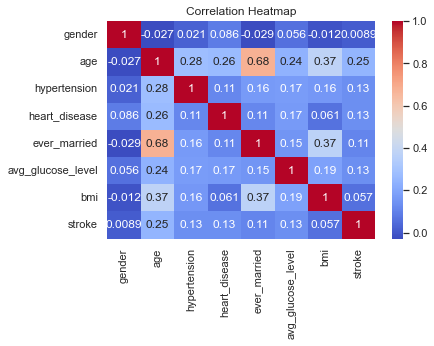

In [150]:
# correalation analysis
import seaborn as sns
# correlation matrix
correlation_matrix = df.corr()
print(correlation_matrix)
# visualizing the correlation matrix using a heatmap.
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

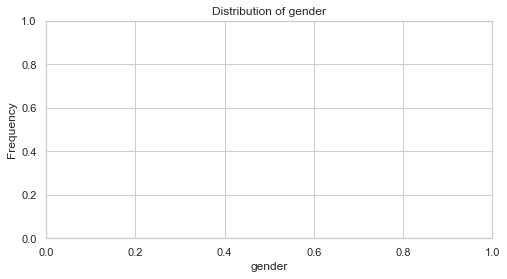

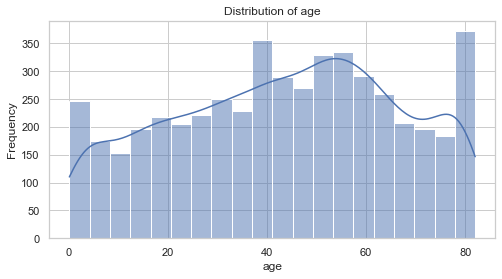

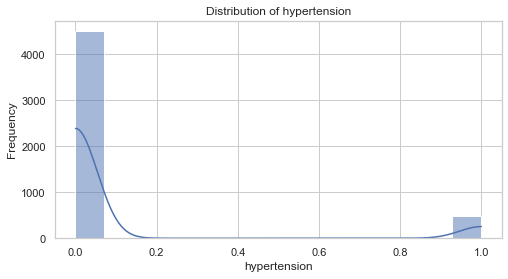

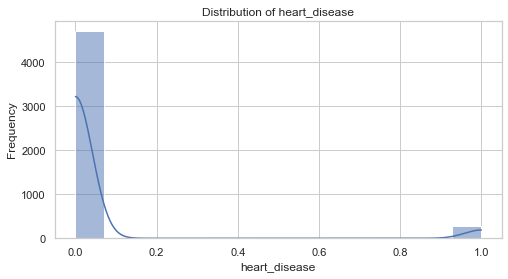

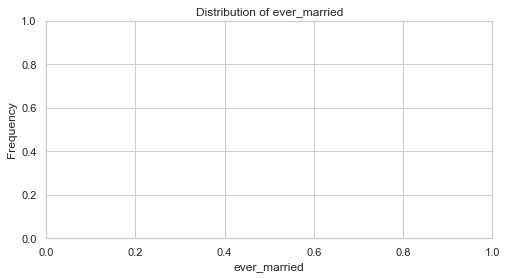

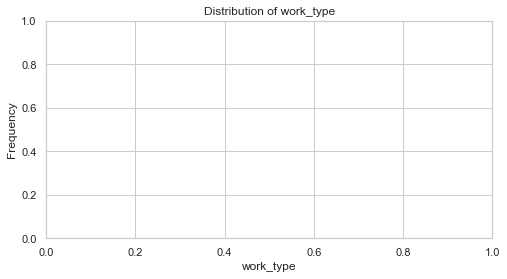

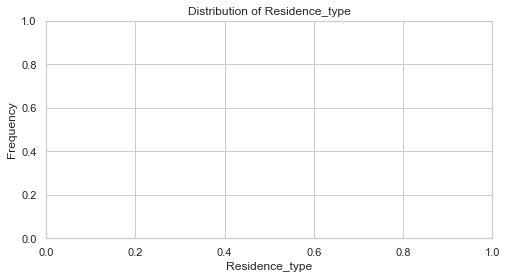

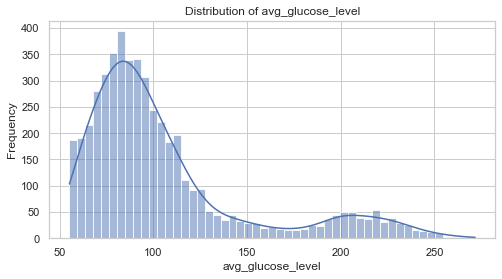

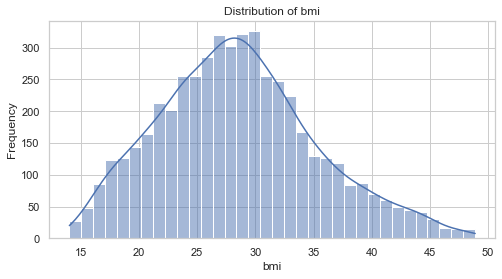

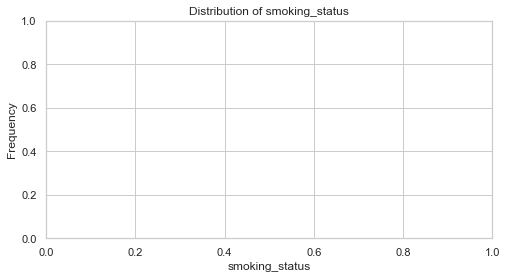

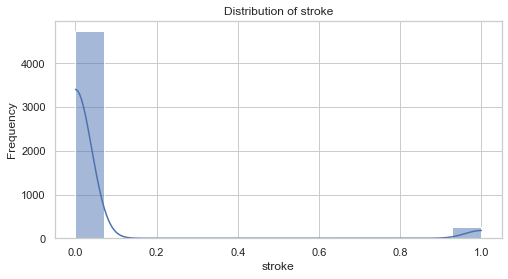

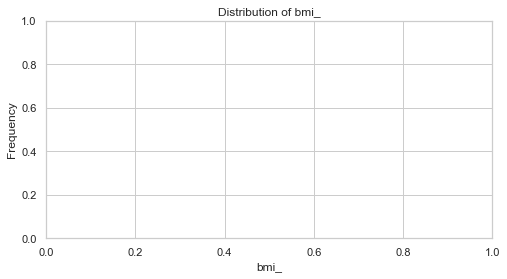

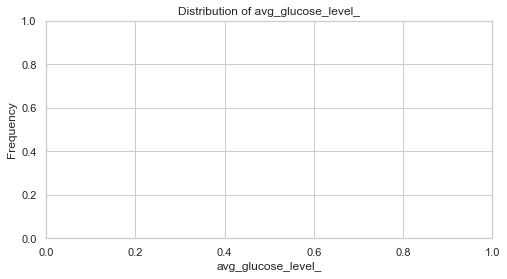

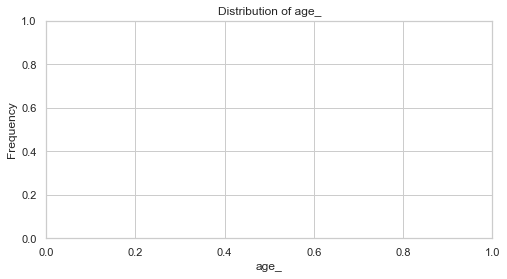

In [151]:
# plot style
sns.set(style="whitegrid")

# plot distribution
for column in df.columns:
    plt.figure(figsize=(8, 4))
    if df[column].dtype == 'int64' or df[column].dtype == 'float64':
        sns.histplot(data=df, x=column, kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()


It can be observed that among stroke patients:

Previous smokers and the proportion of smokers are 28.34% and 17%, respectively.
The majority of patients are obese, accounting for a high percentage of 66.8%, followed by overweight at 23.48%.
Most of them are elderly patients, with a high percentage of 63.16% in the age range from 66 to 82 years.
The differences in residential type and gender are generally consistent.
Among stroke patients, 55.06% have diabetes, and 10.93% have low blood sugar.
Patients with heart disease and high blood pressure are relatively few, at 19.03% and 26.72%, respectively.
Among patients, the most common job type is private enterprise, followed by self-employed individuals.
88.66% of patients have been married, but based on age groups, it can be seen that most patients are in the marriageable age range, so having been married may not be a significant factor affecting stroke.
# Feature Engineering


In [152]:
X = data.iloc[:,[5,6,9,0,1,2,3,4,7,8]]  # Adjust column sequence
X.iloc[:,:3] = OrdinalEncoder().fit_transform(X.iloc[:,:3])  # Encode first three columns
Y = data['stroke']  # Target variable
X.info()  # Display X info
data.info()  # Display data info


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4872 entries, 0 to 4980
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   work_type          4872 non-null   float64
 1   Residence_type     4872 non-null   float64
 2   smoking_status     4872 non-null   float64
 3   gender             4872 non-null   int64  
 4   age                4872 non-null   float64
 5   hypertension       4872 non-null   int64  
 6   heart_disease      4872 non-null   int64  
 7   ever_married       4872 non-null   int64  
 8   avg_glucose_level  4872 non-null   float64
 9   bmi                4872 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 418.7 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4872 entries, 0 to 4980
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   gender              4872 non-null   int64   
 1   age

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16340\3429381376.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.iloc[:,:3] = OrdinalEncoder().fit_transform(X.iloc[:,:3])  # Encode first three columns


## Feature Selection

In [153]:
from sklearn.feature_selection import chi2

# Compute chi-squared stats between each feature in X and target Y
chivalue, p = chi2(X,Y)

# Print features with p-values greater than 0.05
print('Fields with p-values greater than 0.05 are:',X.columns[p>0.05].tolist())

# Create a list of tuples with feature names and their p-values
[*zip(X.columns,p)]

Fields with p-values greater than 0.05 are: ['work_type', 'Residence_type', 'smoking_status', 'gender']


[('work_type', 0.06909799102849495),
 ('Residence_type', 0.4405288669315618),
 ('smoking_status', 0.1583045792187553),
 ('gender', 0.5635721436020631),
 ('age', 0.0),
 ('hypertension', 3.678941881920117e-18),
 ('heart_disease', 1.0193132357740084e-19),
 ('ever_married', 2.7246118655633048e-05),
 ('avg_glucose_level', 0.0),
 ('bmi', 4.994439020769269e-06)]

In [154]:
del X['Residence_type']
del X['gender']
X.head()

,work_type,smoking_status,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi
0,1.0,1.0,67.0,0,1,1,228.69,36.6
1,1.0,2.0,80.0,0,1,1,105.92,32.5
2,1.0,3.0,49.0,0,0,1,171.23,34.4
3,2.0,2.0,79.0,1,0,1,174.12,24.0
4,1.0,1.0,81.0,0,0,1,186.21,29.0



## Upsampling
In the data, there is a severe class imbalance, with only 5% of stroke cases. Therefore, upsampling is needed to balance the data.

In [155]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE with a specific random state
sm = SMOTE(random_state=1)

# Resample the dataset using SMOTE
X, Y = sm.fit_resample(X, Y)

# Calculate the number of samples and the counts of each class
n_sample_ = X.shape[0]
n_1_sample = pd.Series(Y).value_counts()[1]
n_0_sample = pd.Series(Y).value_counts()[0]

# Print the sample count and percentage of each class
print('Sample num：{}; 1：{:.2%}; 0：{:.2%}'.format(n_sample_, n_1_sample/n_sample_, n_0_sample/n_sample_))

Sample num：9250; 1：50.00%; 0：50.00%


## Splitting the Training Set

In [156]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size=0.3,random_state=1)


# Calculate the proportions of training and testing sets
train_percentage = xtrain.shape[0] / (xtrain.shape[0] + xtest.shape[0]) * 100
test_percentage = 100 - train_percentage

# Display the distribution proportions of the training and testing sets
print(f"Training set: {train_percentage:.2f}%")
print(f"Testing set: {test_percentage:.2f}%")

Training set: 70.00%
Testing set: 30.00%


# Model Prediction 
## Decision Tree

0.9084772615120901


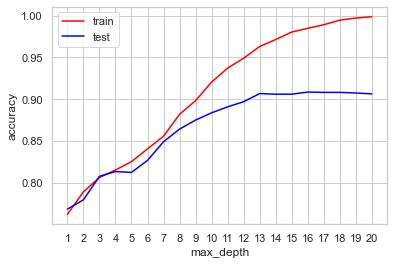

In [157]:
model_list = []  # List to store model scores

from sklearn.tree import DecisionTreeClassifier as DTC

tr = []  # List to store training scores
te = []  # List to store test scores

# Train and evaluate the model for different max_depth values
for i in range(20):
    clf = DTC(random_state=1, max_depth=i+1)  # Initialize the classifier with current max_depth
    clf = clf.fit(xtrain, ytrain)  # Train the classifier
    score_tr = clf.score(xtrain, ytrain)  # Evaluate on training data
    score_te = cross_val_score(clf, xtest, ytest, cv=10).mean()  # Evaluate on test data using cross-validation
    tr.append(score_tr)
    te.append(score_te)

print(max(te))  # Print the maximum test score

# Plot the training and test scores
plt.plot(range(1, 21), tr, color='red', label='train')
plt.plot(range(1, 21), te, color='blue', label='test')
plt.xticks(range(1, 21))
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.show()

model_list.append(max(te))  # Append the maximum test score to the model_list

It can be observed that in the decision tree model, as the depth of the tree increases, the model's performance improves. It reaches its highest performance in the test set at 91.78%. However, the depth has already exceeded 10 layers, which would consume a significant amount of computing power. Therefore, we consider using other models for fitting.

## Random Forest

0.9409020076357685


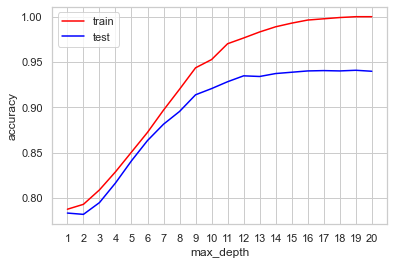

In [158]:
from sklearn.ensemble import RandomForestClassifier as RFC

tr = []  # List to store training scores
te = []  # List to store test scores

# Train and evaluate the model for different max_depth values
for i in range(20):
    rfc = RFC(random_state=2, max_depth=i+1, n_estimators=100)  # Initialize the classifier with current max_depth
    rfc = rfc.fit(xtrain, ytrain)  # Train the classifier
    score_tr = rfc.score(xtrain, ytrain)  # Evaluate on training data
    score_te = cross_val_score(rfc, xtest, ytest, cv=10).mean()  # Evaluate on test data using cross-validation
    tr.append(score_tr)
    te.append(score_te)

print(max(te))  # Print the maximum test score

# Plot the training and test scores
plt.plot(range(1, 21), tr, color='red', label='train')
plt.plot(range(1, 21), te, color='blue', label='test')
plt.xticks(range(1, 21))
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.show()

model_list.append(max(te))  # Append the maximum test score to the model_list


Similarly, in the random forest model, it can be observed that as the depth of the trees increases, the model's performance improves. It reaches its highest performance in the test set at 94.59%. However, the depth has also exceeded 10 layers. Therefore, we also consider using other models for fitting.

## LGB

[LightGBM] [Info] Number of positive: 3237, number of negative: 3238
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 6475, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499923 -> initscore=-0.000309
[LightGBM] [Info] Start training from score -0.000309
[LightGBM] [Info] Number of positive: 3237, number of negative: 3238
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 6475, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499923 -> initscore=-0.000309
[Lig

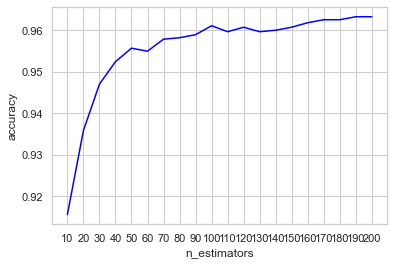

In [159]:
from lightgbm import LGBMClassifier as LGB
from sklearn.metrics import accuracy_score

te = []  # List to store test scores

# Train and evaluate the model for different n_estimators values
for i in np.arange(10, 210, 10):
    lgb = LGB(random_state=1, n_estimators=i)  # Initialize the classifier with current n_estimators
    lgb.fit(xtrain, ytrain)  # Train the classifier
    ypred = lgb.predict(xtest)  # Predict on test data
    te.append(accuracy_score(ytest, ypred))  # Evaluate the predictions

print(max(te))  # Print the maximum test score

# Plot the test scores
plt.plot(np.arange(10, 210, 10), te, color='blue')
plt.xticks(np.arange(10, 210, 10))
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.show()


In [160]:
##grid search cost long time to run
# from sklearn.model_selection import GridSearchCV
# params = {'learning_rate': np.linspace(0.3,0.5,10),
#           'n_estimators':range(130,141)
#           ,'max_depth':range(10)
#         }
# lgb = LGB(random_state=1)
# GS = GridSearchCV(estimator=lgb, param_grid=params, scoring='accuracy', cv=5)
# GS.fit(xtest, ytest)

In contrast, the LGB model performs better. Therefore, we perform a grid search to find the optimal parameters. Please note that grid search can take a long time, so you can adjust the parameter ranges as needed. 
Here, we have commented out this part of the code. The final model parameters and performance are as follows, and we can see an improvement of 0.216%.

In [161]:
lgb = LGB(random_state=1,n_estimators=137,learning_rate=0.35556)
lgb.fit(xtrain,ytrain)
ypred = lgb.predict(xtest)
print(accuracy_score(ytest, ypred))
model_list.append(accuracy_score(ytest, ypred))

[LightGBM] [Info] Number of positive: 3237, number of negative: 3238
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 6475, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499923 -> initscore=-0.000309
[LightGBM] [Info] Start training from score -0.000309
0.9618018018018017


## Model Comparison

In [162]:
# Create a DataFrame for model accuracies
model_list = pd.DataFrame(model_list,['Decision Tree','Random Forest','LGB'])
model_list = model_list.reset_index()
model_list.columns = ['model','accuracy']
# Create a bar chart for model accuracies
bar = (
    Bar()
    .add_xaxis(model_list['model'].tolist())
    .add_yaxis("Accuracy", (model_list['accuracy']*100).round(3).tolist(),z=1)
    .set_global_opts(
        title_opts=opts.TitleOpts(title="Comparison of accuracy of different models"),
        tooltip_opts=opts.TooltipOpts(
            is_show=True, trigger="axis", axis_pointer_type="cross"
        ),
        xaxis_opts=opts.AxisOpts(
            type_="category",
            axispointer_opts=opts.AxisPointerOpts(is_show=True, type_="shadow"),
        )
        ,yaxis_opts=opts.AxisOpts(
            min_=90
        )
    )
)
bar.render_notebook()


In [163]:
# Create a DataFrame showing feature importances from the LightGBM model
pd.DataFrame([*zip(X.columns,lgb.feature_importances_)]
,columns=['col','feature_importances_']).sort_values(
    'feature_importances_',ascending=False)

,col,feature_importances_
6,avg_glucose_level,1258
2,age,1087
7,bmi,1022
1,smoking_status,349
0,work_type,241
4,heart_disease,53
5,ever_married,52
3,hypertension,48


By comparison, the LGB model achieves the highest accuracy, reaching 96.649%. Combining the `feature_importances_`, we can observe that the most important factors influencing the model's fit are **average glucose level**, followed by **age** and **BMI**.